In [1]:
import tensorflow as tf
import time
from datetime import timedelta
import numpy as np
ks=tf.keras

## 1. Data

In [20]:
from kgcnn.graph.base import GraphDict
from kgcnn.data.base import MemoryGraphList, MemoryGraphDataset
from kgcnn.data.qm import QMDataset
from kgcnn.literature.HDNNP2nd import make_model_behler
from kgcnn.training.scheduler import LinearLearningRateScheduler

In [3]:
# dataset = QMDataset(data_directory="ExampleQM", file_name="ThiolDisulfidExchange.csv", dataset_name="ThiolDisulfidExchange")
# dataset.prepare_data(overwrite=True, make_sdf = True);
# dataset.read_in_memory(label_column_name="energy");
# dataset.map_list(method="set_range", max_distance=5.0);
# dataset.map_list(method="set_angle");
# dataset.save();

In [4]:
dataset = MemoryGraphDataset(data_directory="ExampleQM", dataset_name="ThiolDisulfidExchange")
dataset.load();
dataset[0].keys()

INFO:kgcnn.data.ThiolDisulfidExchange:Load pickled dataset...


dict_keys(['node_symbol', 'node_number', 'node_coordinates', 'edge_indices', 'edge_number', 'graph_labels', 'range_indices', 'range_attributes', 'angle_indices', 'angle_indices_nodes', 'angle_attributes', 'rep'])

## 2. Model

In [5]:
#from kgcnn.literature.HDNNP2nd import make_model
make_model = make_model_behler

In [6]:
elemental_mapping = [1,6,16]

# Radial parameters
cutoff_rad = 10
Rs_array   = [0.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
eta_array  = [0.0, 0.03, 0.08, 0.16, 0.3, 0.5]

# Angular parameters
cutoff_ang    = 6
lambd_array   = [-1, 1]
zeta_array    = [1, 2, 4, 8, 16]
eta_ang_array = eta_array

In [7]:
model_config = {
    "name": "HDNNP2nd",
    "inputs": [{"shape": (None,), "name": "node_number", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32", "ragged": True},
               {"shape": (None, 2), "name": "edge_indices", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "angle_indices_nodes", "dtype": "int64", "ragged": True}],
    "g2_kwargs": {"eta": eta_array, "rs": Rs_array, "rc": cutoff_rad, "elements": elemental_mapping},
    "g4_kwargs": {"eta": eta_ang_array, "zeta": zeta_array, "lamda": lambd_array, "rc": cutoff_ang, "elements": elemental_mapping},
    "mlp_kwargs": {"units": [35, 1],
                   "num_relations": max(elemental_mapping)+1,
                   "activation": ["tanh", "linear"]},
    "node_pooling_args": {"pooling_method": "sum"},
    "verbose": 10,
    "output_embedding": "graph", "output_to_tensor": True,
    "use_output_mlp": False,
    "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                   "activation": ["tanh", "linear"]}
}

In [8]:
model = make_model(**model_config);

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'HDNNP2nd', 'inputs': [{'shape': (None,), 'name': 'node_number', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'node_coordinates', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'angle_indices_nodes', 'dtype': 'int64', 'ragged': True}], 'g2_kwargs': {'eta': [0.0, 0.03, 0.08, 0.16, 0.3, 0.5], 'rs': [0.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0], 'rc': 10, 'elements': [1, 6, 16]}, 'g4_kwargs': {'eta': [0.0, 0.03, 0.08, 0.16, 0.3, 0.5], 'lamda': [-1, 1], 'rc': 6, 'zeta': [1, 2, 4, 8, 16], 'elements': [1, 6, 16], 'multiplicity': 2.0}, 'normalize_kwargs': {}, 'mlp_kwargs': {'units': [35, 1], 'num_relations': 17, 'activation': ['tanh', 'linear']}, 'node_pooling_args': {'pooling_method': 'sum'}, 'verbose': 10, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_output_mlp': False, 'output_mlp': {'use_bias

In [9]:
inputs = dataset.tensor(model_config["inputs"])
len(inputs), inputs[0].shape, inputs[1].shape, inputs[2].shape, inputs[3].shape

(4,
 TensorShape([5112, None]),
 TensorShape([5112, None, 3]),
 TensorShape([5112, None, 2]),
 TensorShape([5112, None, 3]))

In [10]:
from kgcnn.scaler.mol import ExtensiveMolecularScaler
scaler = ExtensiveMolecularScaler(standardize_scale=False)
labels = np.expand_dims(np.array(dataset.get("graph_labels"))/0.0367493, axis=-1)
labels = scaler.fit_transform(labels, atomic_number=dataset.get("node_number"))
labels.shape

(5112, 1)

In [11]:
from sklearn.model_selection import KFold
kf = KFold(n_splits= 2, random_state=42, shuffle=True)

In [12]:
from kgcnn.layers.modules import LazyConcatenate
from kgcnn.layers.conv.acsf_conv import ACSFG2, ACSFG4

__model_version__ = "2023.01.09"

def make_model_rep( inputs: list = None,
                    name: str = None,
                    verbose: int = None,
                    g2_kwargs: dict = None,
                    g4_kwargs: dict = None,
                    ):
    # Make input
    node_input = ks.layers.Input(**inputs[0])
    xyz_input = ks.layers.Input(**inputs[1])
    edge_index_input = ks.layers.Input(**inputs[2])
    angle_index_input = ks.layers.Input(**inputs[3])

    # ACSF representation.
    rep_g2 = ACSFG2(**ACSFG2.make_param_table(**g2_kwargs))([node_input, xyz_input, edge_index_input])
    rep_g4 = ACSFG4(**ACSFG4.make_param_table(**g4_kwargs))([node_input, xyz_input, angle_index_input])
    rep = LazyConcatenate()([rep_g2, rep_g4])
    
    model = ks.models.Model(
        inputs=[node_input, xyz_input, edge_index_input, angle_index_input], outputs=rep, name=name)
    model.__kgcnn_model_version__ = __model_version__
    return model

rep_model_configs = {
    "name": "HDNNP2nd",
    "inputs": [{"shape": (None,), "name": "node_number", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32", "ragged": True},
               {"shape": (None, 2), "name": "edge_indices", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "angle_indices_nodes", "dtype": "int64", "ragged": True}],
    "g2_kwargs": {"eta": eta_array, "rs": Rs_array, "rc": cutoff_rad, "elements": elemental_mapping},
    "g4_kwargs": {"eta": eta_ang_array, "zeta": zeta_array, "lamda": lambd_array, "rc": cutoff_ang, "elements": elemental_mapping}
}
rep_model = make_model_rep(**rep_model_configs)
#rep = rep_model.predict(dataset.tensor(rep_model_configs["inputs"]))


In [13]:
# for i in range(len(dataset)):
#     dataset[i].set("rep", rep[i])
# dataset.tensor({"shape": (None,None,None), "name": "rep", "dtype": "float32", "ragged": True}).shape

In [14]:
from kgcnn.layers.mlp import RelationalMLP
from kgcnn.layers.pooling import PoolingNodes
from kgcnn.layers.mlp import GraphMLP, MLP
from kgcnn.layers.casting import ChangeTensorType

def make_model_learn(   inputs: list = None,
                        node_pooling_args: dict = None,
                        name: str = None,
                        verbose: int = None,
                        mlp_kwargs: dict = None,
                        output_embedding: str = None,
                        use_output_mlp: bool = None,
                        output_to_tensor: bool = None,
                        output_mlp: dict = None):
    
    rep_input  = ks.layers.Input(**inputs[0])
    node_input = ks.layers.Input(**inputs[1])
    
    # learnable NN.
    n = RelationalMLP(**mlp_kwargs)([rep_input, node_input])

    # Output embedding choice
    if output_embedding == 'graph':
        out = PoolingNodes(**node_pooling_args)(n)
        if use_output_mlp:
            out = MLP(**output_mlp)(out)
    elif output_embedding == 'node':
        out = n
        if use_output_mlp:
            out = GraphMLP(**output_mlp)(out)
        if output_to_tensor:  # For tf version < 2.8 cast to tensor below.
            out = ChangeTensorType(input_tensor_type="ragged", output_tensor_type="tensor")(out)
    else:
        raise ValueError("Unsupported output embedding for mode `HDNNP2nd`")

    model = ks.models.Model(
        inputs=[rep_input, node_input], outputs=out, name=name)
    model.__kgcnn_model_version__ = __model_version__
    return model

model_learn_config = {
    "name": "HDNNP2nd",
    "inputs": [{"shape": (None, 486), "name": "rep", "dtype": "float32", "ragged": True},
               {"shape": (None,), "name": "node_number", "dtype": "int64", "ragged": True}],
    "mlp_kwargs": {"units": [35, 35, 1],
                   "num_relations": max(elemental_mapping)+1,
                   "activation": ["tanh", "tanh", "linear"]},
    "node_pooling_args": {"pooling_method": "sum"},
    "verbose": 10,
    "output_embedding": "graph", "output_to_tensor": True,
    "use_output_mlp": False,
    "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                   "activation": ["tanh", "linear"]}
}

In [21]:
hists = []
for train_index, test_index in kf.split(X=labels):
    model = make_model_learn(**model_learn_config)
    model.compile(loss="mean_absolute_error", metrics=["mean_absolute_error"], 
                  optimizer=ks.optimizers.Adam(learning_rate=5e-5, decay=1e-5))
    model.summary()
    x_train, y_train = dataset[train_index].tensor(model_learn_config["inputs"]), labels[train_index]
    x_test, y_test = dataset[test_index].tensor(model_learn_config["inputs"]), labels[test_index]
    
    start = time.process_time()
    hist = model.fit(
        x_train, y_train,
        callbacks=[LinearLearningRateScheduler(
            learning_rate_start=1e-3, learning_rate_stop=1e-7, epo_min=0, epo=200)
        ],
        validation_data=(x_test, y_test),
        epochs=200,
    )
    stop = time.process_time()
    print("Print Time for training: ", str(timedelta(seconds=stop - start)))
    hists.append(hist)

c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "HDNNP2nd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rep (InputLayer)               [(None, None, 486)]  0           []                               
                                                                                                  
 node_number (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 relational_mlp_3 (RelationalML  (None, None, 1)     310661      ['rep[0][0]',                    
 P)                                                               'node_number[0][0]']            
                                                                                                  
 pooling_embedding_3 (PoolingEm  (None, 1)           0           ['relational_mlp_3[0][0]']

In [16]:
# hists = []
# for train_index, test_index in kf.split(X=labels):
#     model = make_model(**model_config)
#     model.compile(loss="mean_absolute_error", metrics=["mean_absolute_error"], 
#                   optimizer=ks.optimizers.Adam(learning_rate=5e-5))
    
#     x_train, y_train = dataset[train_index].tensor(model_config["inputs"]), labels[train_index]
#     x_test, y_test = dataset[test_index].tensor(model_config["inputs"]), labels[test_index]
    
#     start = time.process_time()
#     hist = model.fit(
#         x_train, y_train,
#         validation_data=(x_test, y_test),
#         epochs=100,
#     )
#     stop = time.process_time()
#     print("Print Time for training: ", str(timedelta(seconds=stop - start)))
#     model.summary()
#     hists.append(hist)

In [22]:
true_y = scaler.inverse_transform(labels[test_index], atomic_number=dataset[test_index].get("node_number"))
predicted_y = scaler.inverse_transform(model.predict(x_test), atomic_number=dataset[test_index].get("node_number"))

80/80 [==============================] - 2s 13ms/step


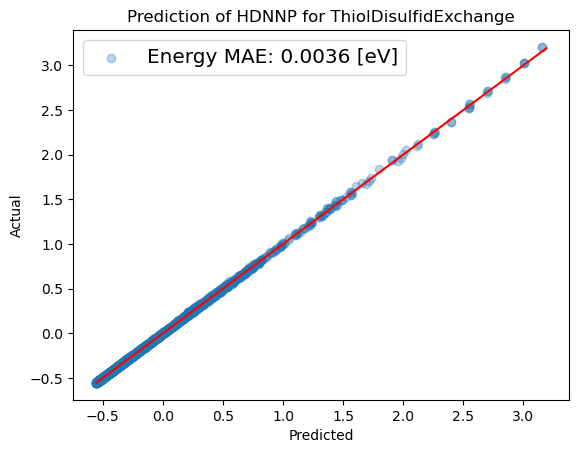

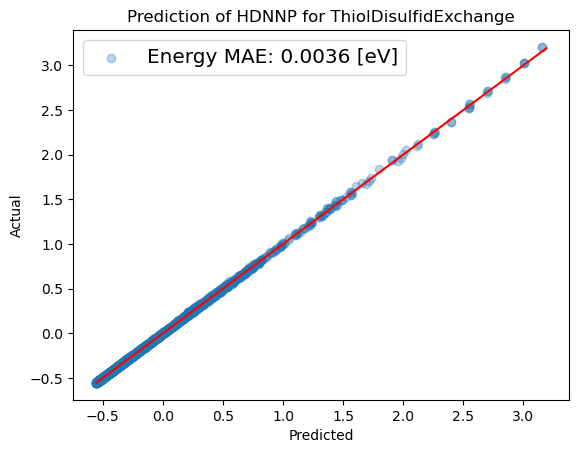

In [23]:
from kgcnn.utils.plots import plot_predict_true
plot_predict_true(predicted_y, true_y,
                  filepath="ExampleQM/", data_unit="eV",
                  model_name="HDNNP", dataset_name="ThiolDisulfidExchange", target_names="Energy",
                  file_name=f"predict.png")

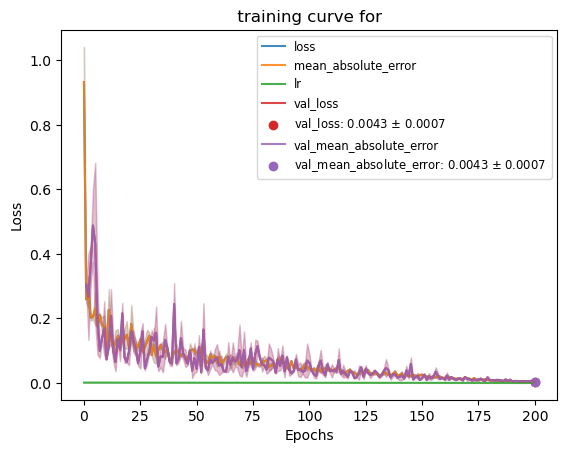

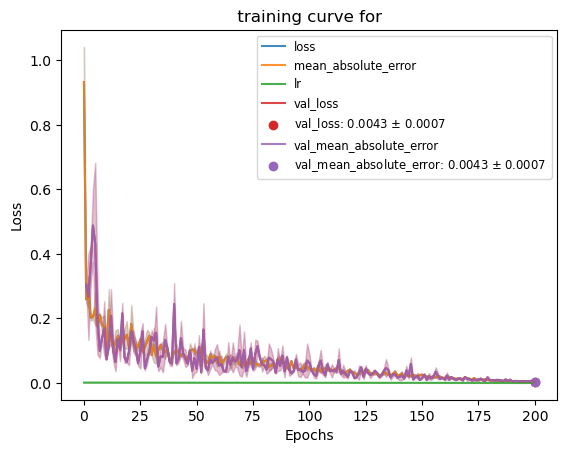

In [24]:
from kgcnn.utils.plots import plot_train_test_loss
plot_train_test_loss(hists)
